# 02/01/23 - This notebook takes the chains from 1/31 models and shows the plots, saving the figures.

In [1]:
################################################################
# set mass model, anisotropy, and alignment
model = 'power_law'
anisotropy = 'const'
align = 'sph'
# set nstep
nstep=1000
################################################################

################################################################

# import general libraries and modules
import numpy as np
np.set_printoptions(threshold=10000)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 18})
import pandas as pd
import warnings
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
warnings.filterwarnings( "ignore", module = "plotbin\..*" )
import os
from os import path
import glob
import pickle
from datetime import datetime

# astronomy/scipy
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import rotate
from scipy.ndimage import map_coordinates
from scipy.optimize import least_squares as lsq
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
from astropy.cosmology import Planck15 as cosmo # I took 15 because for some reason Planck18 isn't in this astropy install #Planck18 as cosmo  # Planck 2018
from scipy.interpolate import interp1d
from scipy.optimize import fsolve

# mge fit
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

# jam
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_axi_proj import rotate_points
from jampy.jam_axi_proj import bilinear_interpolate
from jampy.mge_half_light_isophote import mge_half_light_isophote
from plotbin.plot_velfield import plot_velfield
from plotbin.sauron_colormap import register_sauron_colormap
register_sauron_colormap()
from pafit.fit_kinematic_pa import fit_kinematic_pa
from jampy.jam_axi_proj import jam_axi_proj
from jampy.mge_radial_mass import mge_radial_mass
from plotbin.symmetrize_velfield import symmetrize_velfield

# adamet
from adamet.adamet import adamet
from adamet.corner_plot import corner_plot

# my functions
import sys
sys.path.append("/home/shawnknabel/Documents/slacs_kinematics/my_python_packages")
#from slacs_mge_jampy import crop_center_image
#from slacs_mge_jampy import import_center_crop
#from slacs_mge_jampy import try_fractions_for_find_galaxy
#from slacs_mge_jampy import convert_mge_model_outputs
#from slacs_mge_jampy import plot_contours_321
#from slacs_mge_jampy import load_2d_kinematics
#from slacs_mge_jampy import bin_velocity_maps
#from slacs_mge_jampy import show_pa_difference
#from slacs_mge_jampy import rotate_bins
#from slacs_mge_jampy import correct_bin_rotation
#from slacs_mge_jampy import find_half_light
#from slacs_mge_jampy import calculate_minlevel
#from slacs_mge_jampy import fit_kcwi_sigma_psf
#from slacs_mge_jampy import optimize_sigma_psf_fit
#from slacs_mge_jampy import estimate_hst_psf
from slacs_ani_mass_jam import osipkov_merritt_model
from slacs_ani_mass_jam import osipkov_merritt_generalized_model
from slacs_ani_mass_jam import inner_outer_anisotropy_model
from slacs_ani_mass_jam import nfw_generalized_model
from slacs_ani_mass_jam import dark_halo_mge
from slacs_ani_mass_jam import total_mass_mge
from slacs_ani_mass_jam import jam_lnprob
from slacs_ani_mass_jam import jam_lnprob_power_law
from slacs_ani_mass_jam import jam_lnprob_nfw_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfwgen_constbeta
from slacs_ani_mass_jam import jam_lnprob_nfw_om
from slacs_ani_mass_jam import jam_lnprob_nfwgen_om
from slacs_ani_mass_jam import summary_plot
from slacs_ani_mass_jam import save_fit_parameters
from slacs_ani_mass_jam import get_power_law_slope
from slacs_ani_mass_jam import jampy_details
from slacs_ani_mass_jam import prepare_to_jam
from slacs_ani_mass_jam import space_jam
from slacs_mge_jampy import make_gaussian

################################################################
# some needed information
kcwi_scale = 0.1457  # arcsec/pixel
hst_scale = 0.050 # ACS/WFC

# specify object directory and names
data_dir = '/data/raw_data/KECK_KCWI_SLACS_kinematics_shawn/' # data directory

#################################################
# objects
obj_names = ['SDSSJ0029-0055',
             'SDSSJ0037-0942',
             'SDSSJ0330-0020',
             'SDSSJ1112+0826',
             'SDSSJ1204+0358',
             'SDSSJ1250+0523',
             'SDSSJ1306+0600',
             'SDSSJ1402+6321',
             'SDSSJ1531-0105',
             'SDSSJ1538+5817',
             'SDSSJ1621+3931',
             'SDSSJ1627-0053',
             'SDSSJ1630+4520',
             'SDSSJ2303+1422'
            ]


###################################################################################
    Showing object SDSSJ0029-0055.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.692 +/- 0.097
   $q_{\rm min}$ = 0.2460 +/- 0.18
   $\sigma_z/\sigma_R$ = 0.5336 +/- 0.16
   $\lg(M_\ast/L)$ = 0.5245 +/- 0.084
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


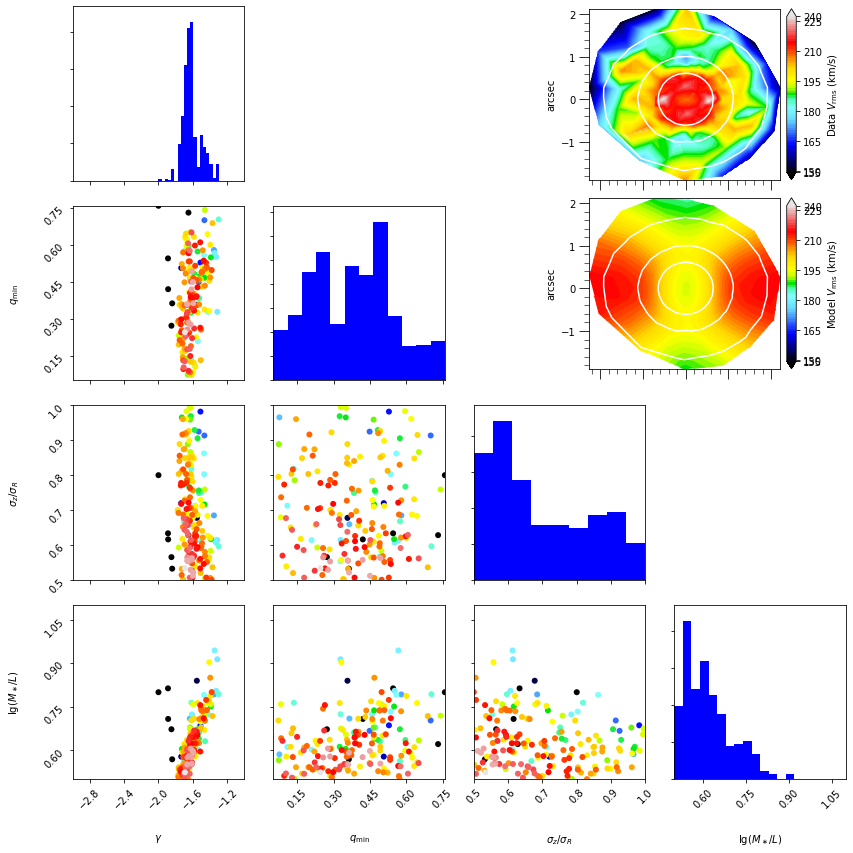

###################################################################################
    Showing object SDSSJ0037-0942.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.795 +/- 0.10
   $q_{\rm min}$ = 0.5792 +/- 0.11
   $\sigma_z/\sigma_R$ = 0.5306 +/- 0.16
   $\lg(M_\ast/L)$ = 0.5008 +/- 0.11
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


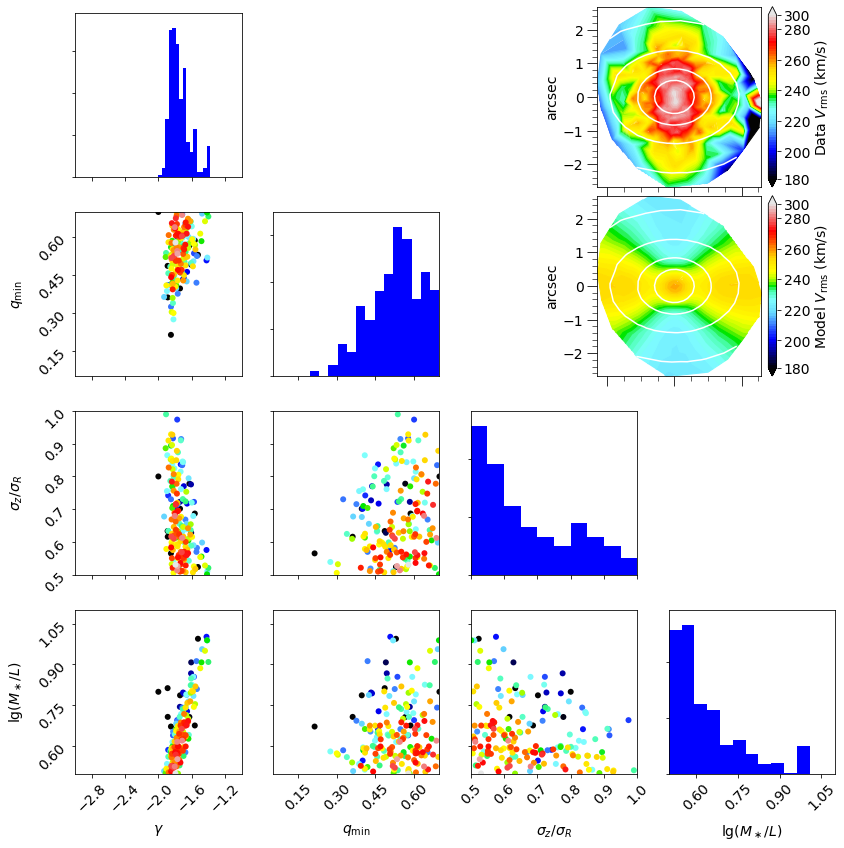

###################################################################################
    Showing object SDSSJ0330-0020.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.834 +/- 0.26
   $q_{\rm min}$ = 0.2605 +/- 0.17
   $\sigma_z/\sigma_R$ = 0.5704 +/- 0.19
   $\lg(M_\ast/L)$ = 0.6593 +/- 0.19
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


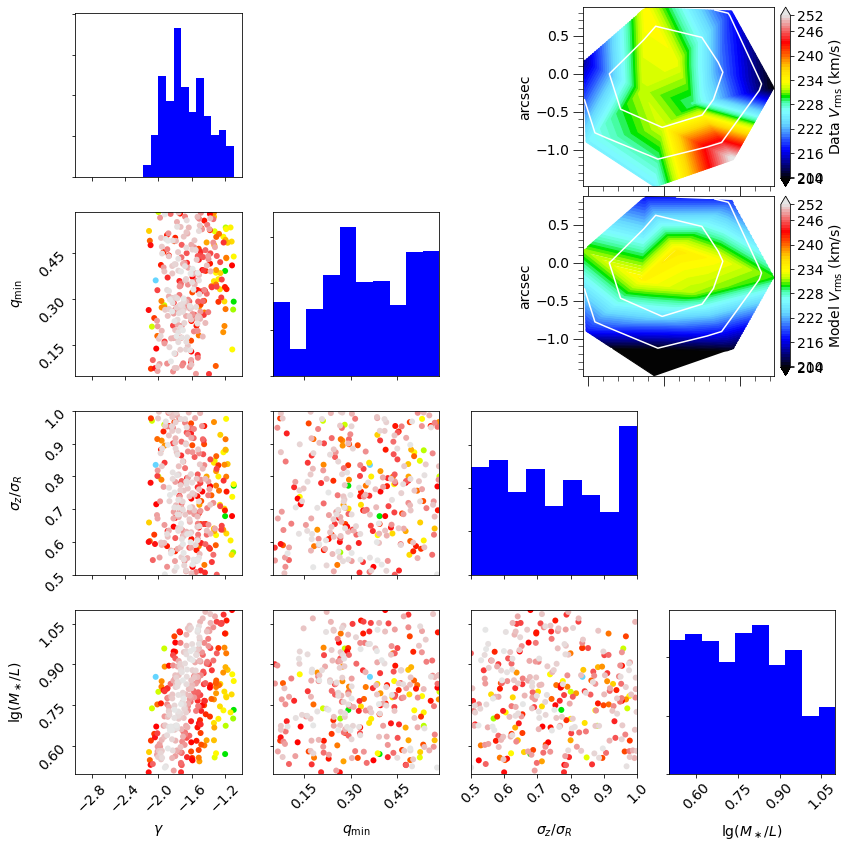

###################################################################################
    Showing object SDSSJ1112+0826.
    
SDSSJ1112+0826 was not modeled in this run.
###################################################################################
    Showing object SDSSJ1204+0358.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.946 +/- 0.14
   $q_{\rm min}$ = 0.8183 +/- 0.23
   $\sigma_z/\sigma_R$ = 0.7809 +/- 0.13
   $\lg(M_\ast/L)$ = 1.080 +/- 0.17


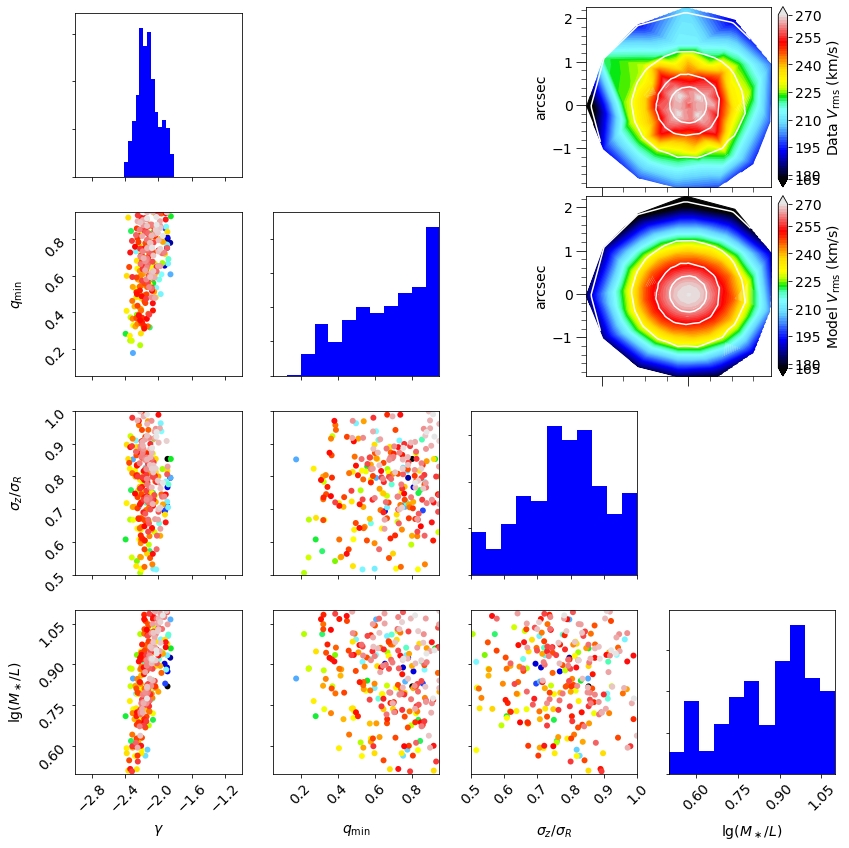

###################################################################################
    Showing object SDSSJ1250+0523.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.999 +/- 0.16
   $q_{\rm min}$ = 0.8761 +/- 0.23
   $\sigma_z/\sigma_R$ = 0.9631 +/- 0.15
   $\lg(M_\ast/L)$ = 0.6584 +/- 0.21


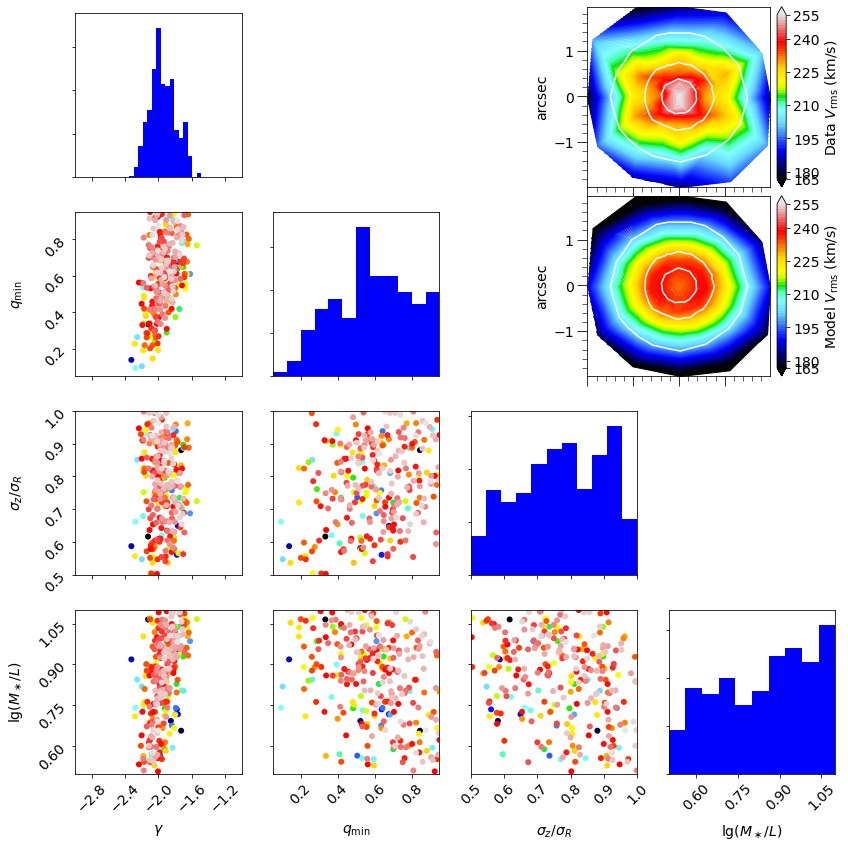

###################################################################################
    Showing object SDSSJ1306+0600.
    
SDSSJ1306+0600 was not modeled in this run.
###################################################################################
    Showing object SDSSJ1402+6321.
    
SDSSJ1402+6321 was not modeled in this run.
###################################################################################
    Showing object SDSSJ1531-0105.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.864 +/- 0.18
   $q_{\rm min}$ = 0.1823 +/- 0.11
   $\sigma_z/\sigma_R$ = 0.5230 +/- 0.17
   $\lg(M_\ast/L)$ = 0.5193 +/- 0.17


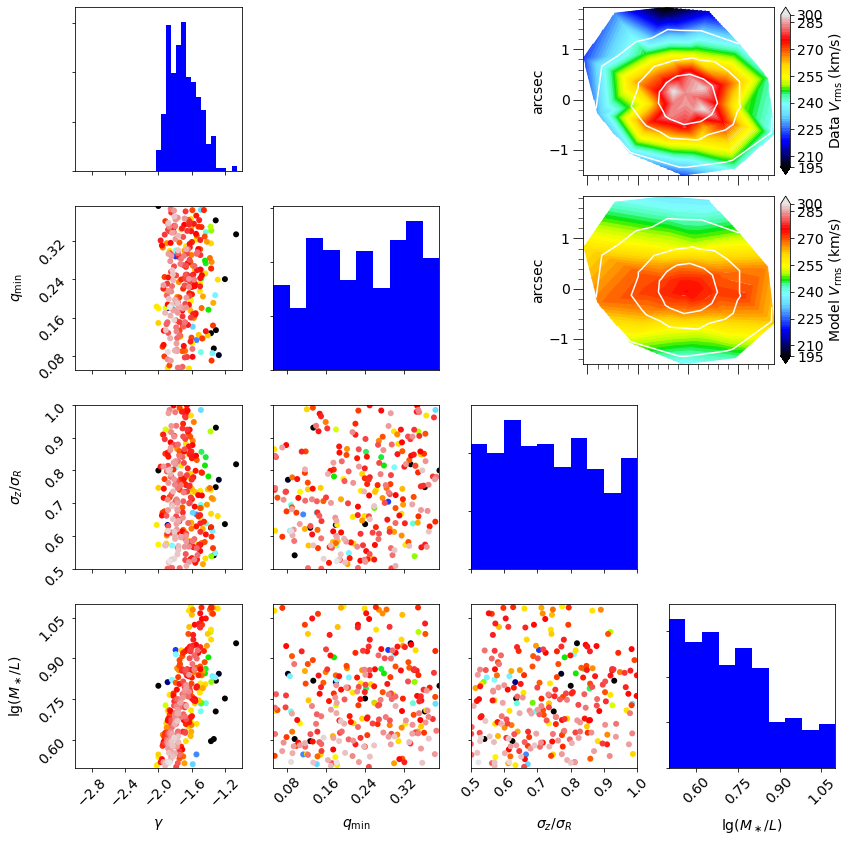

###################################################################################
    Showing object SDSSJ1538+5817.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.982 +/- 0.22
   $q_{\rm min}$ = 0.4417 +/- 0.15
   $\sigma_z/\sigma_R$ = 0.7440 +/- 0.17
   $\lg(M_\ast/L)$ = 0.5870 +/- 0.20


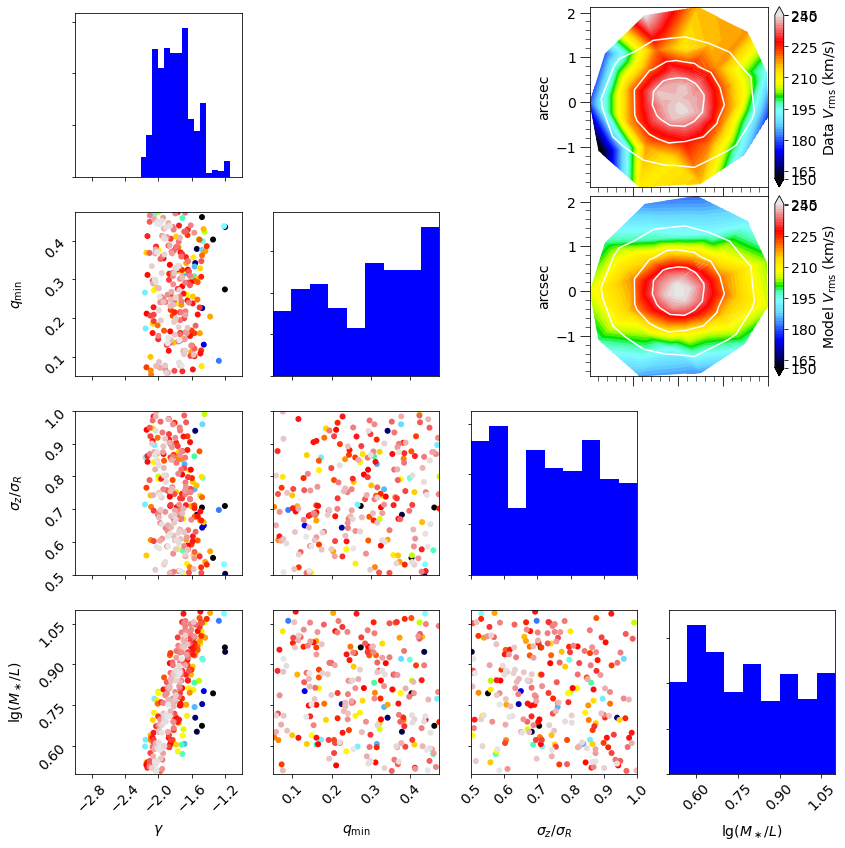

###################################################################################
    Showing object SDSSJ1621+3931.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.579 +/- 0.16
   $q_{\rm min}$ = 0.3517 +/- 0.14
   $\sigma_z/\sigma_R$ = 0.5053 +/- 0.19
   $\lg(M_\ast/L)$ = 0.8910 +/- 0.18
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


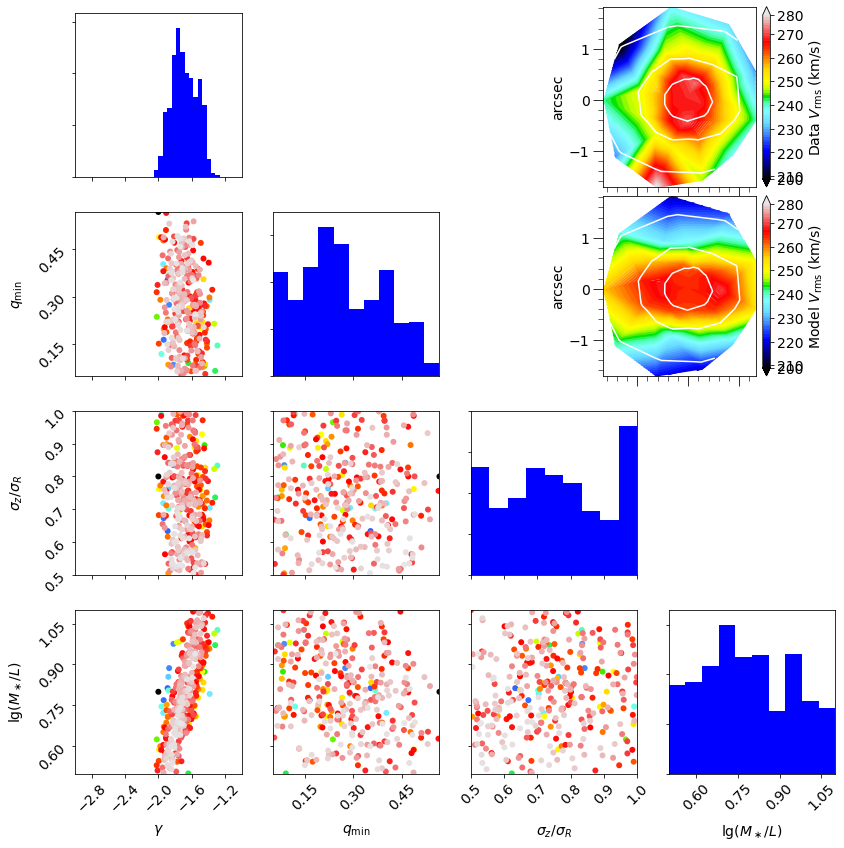

###################################################################################
    Showing object SDSSJ1627-0053.
    

Best-fitting parameters and 1sigma errors:
   $\gamma$ = -1.931 +/- 0.12
   $q_{\rm min}$ = 0.8335 +/- 0.23
   $\sigma_z/\sigma_R$ = 0.9159 +/- 0.16
   $\lg(M_\ast/L)$ = 0.6344 +/- 0.19


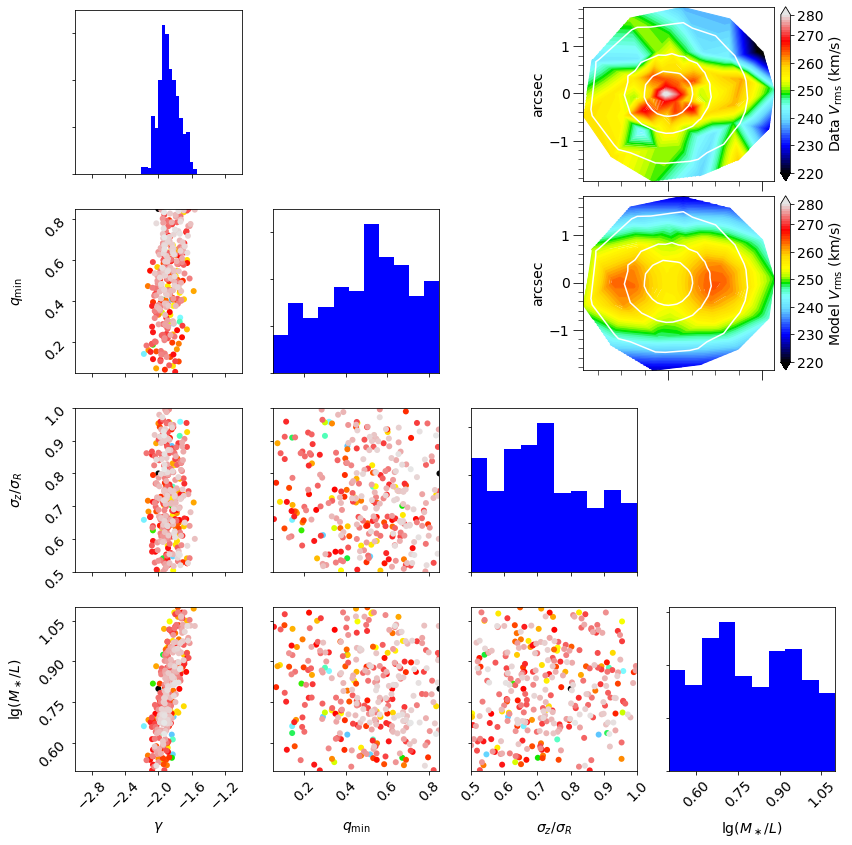

###################################################################################
    Showing object SDSSJ1630+4520.
    
SDSSJ1630+4520 was not modeled in this run.
###################################################################################
    Showing object SDSSJ2303+1422.
    
SDSSJ2303+1422 was not modeled in this run.


In [2]:
for i, obj_name in enumerate(obj_names):
    
    print(f'''###################################################################################
    Showing object {obj_name}.
    ''')
    
    date_time = '2023_01_31'
    jam_prob_func = jam_lnprob_power_law
    
    jam_test_dir = f'{data_dir}jam_testing/2023_01_31/'
    model_dir = glob.glob(f'{jam_test_dir}*{obj_name}*/')
    
    if model_dir:
        model_dir = glob.glob(f'{jam_test_dir}*{obj_name}*/')[0]
        kwargs_file = glob.glob(f'{model_dir}*kwargs.pkl')[0]
        kwargs = pickle.load(open(kwargs_file, 'rb'))
        summary_plot(obj_name, date_time, model_dir, jam_prob_func, kwargs=kwargs, save=True, load=True)
    else:
        print(f'{obj_name} was not modeled in this run.')